# 多层神经网络，Sequential 和 Module
通过前面的章节，我们了解到了机器学习领域中最常见的两个模型，线性回归模型和 Logistic 回归模型，他们分别是处理机器学习中最常见的两类问题-回归问题和分类问题。

下面我们会讲第一个深度学习的模型，多层神经网络。

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral)

这次我们仍然处理一个二分类问题，但是比前面的 logistic 回归更加复杂

In [3]:
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

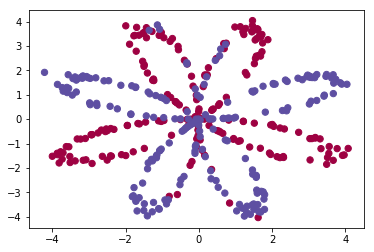

In [4]:
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

我们可以先尝试用 logistic 回归来解决这个问题

In [5]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [6]:
w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    return torch.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

In [7]:
for e in range(100):
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 20, loss: 0.6802895069122314
epoch: 40, loss: 0.6733103394508362
epoch: 60, loss: 0.6731584072113037
epoch: 80, loss: 0.6731497049331665
epoch: 100, loss: 0.6731474995613098


In [10]:
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    out = (out > 0.5) * 1
    return out.data.numpy()

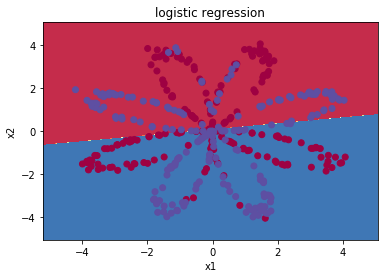

In [12]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

可以看到，logistic 回归并不能很好的区分开这个复杂的数据集，如果你还记得前面的内容，你就知道 logistic 回归是一个线性分类器，这个时候就该我们的神经网络登场了！

In [43]:
# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.01) # 隐藏层神经元个数 2
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def two_network(x):
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1) # 使用 PyTorch 自带的 tanh 激活函数
    x2 = torch.mm(x1, w2) + b2
    return x2

optimizer = torch.optim.SGD([w1, w2, b1, b2], 1.)

criterion = nn.BCEWithLogitsLoss()

In [44]:
# 我们训练 10000 次
for e in range(10000):
    out = two_network(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.2936275005340576
epoch: 2000, loss: 0.27970510721206665
epoch: 3000, loss: 0.2714866101741791
epoch: 4000, loss: 0.26631107926368713
epoch: 5000, loss: 0.2626805305480957
epoch: 6000, loss: 0.2600020170211792
epoch: 7000, loss: 0.2579560875892639
epoch: 8000, loss: 0.2563491761684418
epoch: 9000, loss: 0.2550564408302307
epoch: 10000, loss: 0.2539937198162079


In [45]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1, w2) + b2
    out = F.sigmoid(x2)
    out = (out > 0.5) * 1
    return out.data.numpy()

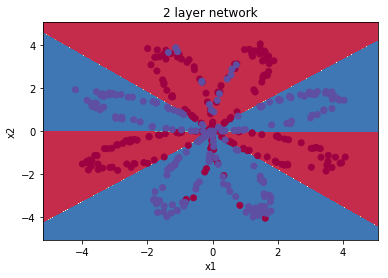

In [47]:
plot_decision_boundary(lambda x: plot_network(x), x.numpy(), y.numpy())
plt.title('2 layer network')

## Sequential 和 Module

我们讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

首先我们会讲一下 PyTorch 中的模块，Sequential 和 Module。

对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

In [73]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(4, 1)
)

In [74]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4)

In [75]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
-0.4162 -0.2470
 0.3472  0.1725
-0.0228 -0.4475
 0.5512  0.5879
[torch.FloatTensor of size 4x2]



In [76]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

In [77]:
# 我们训练 10000 次
for e in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.27858275175094604
epoch: 2000, loss: 0.24435684084892273
epoch: 3000, loss: 0.234076589345932
epoch: 4000, loss: 0.22834795713424683
epoch: 5000, loss: 0.22446087002754211
epoch: 6000, loss: 0.22157138586044312
epoch: 7000, loss: 0.21930493414402008
epoch: 8000, loss: 0.21747057139873505
epoch: 9000, loss: 0.2159590870141983
epoch: 10000, loss: 0.21469680964946747


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些初始化的问题在里面，关于参数初始化，我们会在后面的课程中讲到

In [80]:
def plot_seq(x):
    out = F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

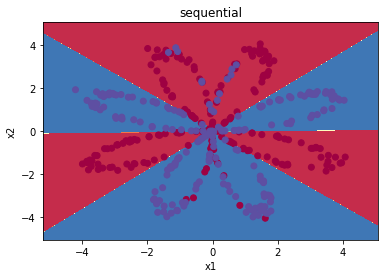

In [81]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

下面我们再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [84]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [85]:
mo_net = module_net(2, 4, 1)

In [86]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4)


In [87]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
 0.1797 -0.2812
-0.4133 -0.2848
 0.3590  0.0036
 0.3904 -0.2332
[torch.FloatTensor of size 4x2]



In [89]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [91]:
# 我们训练 10000 次
for e in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.2635996639728546
epoch: 2000, loss: 0.24222928285598755
epoch: 3000, loss: 0.23339112102985382
epoch: 4000, loss: 0.228009432554245
epoch: 5000, loss: 0.2242368906736374
epoch: 6000, loss: 0.221393883228302
epoch: 7000, loss: 0.2191523164510727
epoch: 8000, loss: 0.21733681857585907
epoch: 9000, loss: 0.2158413529396057
epoch: 10000, loss: 0.21459275484085083


可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便